<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 668.8/668.8 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 KB 4.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 6.0.2 requires pydantic>=1.9.1, but you have pydantic 1.8.2 which is incompatible.
flask 2.2.3 requires click>=8.0, but you have click 7.1.2 which is incompatible.
en-core-web-sm 3.5.0 requires spacy<3.6.0,>=3.5.0, but you have spacy 3.1.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 KB 4.9 MB/s eta 0:00:00


In [2]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [3]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


INFO:stanza:Downloading default packages for language: es (Spanish)...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [4]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

### 3 - Diccionario de entrada

In [ ]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag


In [5]:
dataset = {"intents": [
{
"tag": "welcome",
"patterns": ["Hello", "How are you?", "What's up?", "How's it going?"],
"responses": ["Hello! Welcome to the Olympics, what would you like to know?", "Hello! What are you interested in knowing about the Olympics?"]
},
{
"tag": "participating_countries",
"patterns": ["Which countries participate in the Olympics?", "What countries compete in the Olympics?", "Where are the Olympics held?"],
"responses": ["More than 200 countries participate in the Olympics", "There are many countries that compete in the Olympics"]
},
{
"tag": "sports_events",
"patterns": ["What are the sports events in the Olympics?", "Which sports can be seen in the Olympics?", "How many sports are there in the Olympics?"],
"responses": ["There are many sports that can be seen in the Olympics, such as athletics, swimming, gymnastics, among others", "The Olympics include a wide variety of sports"]
},
{
"tag": "opening_ceremony",
"patterns": ["When is the opening ceremony of the Olympics?", "Who lights the cauldron in the opening ceremony?", "What is the opening ceremony of the Olympics like?"],
"responses": ["The opening ceremony of the Olympics is held at the beginning of the event, with a great spectacle and a parade of athletes", "The lighting of the cauldron is a very emotional moment in the opening ceremony"]
},
{
"tag": "medals",
"patterns": ["How are medals awarded in the Olympics?", "How many medals can be won in the Olympics?", "Which countries have won the most medals in the Olympics?"],
"responses": ["Medals are awarded to athletes who achieve the best results in their disciplines, and are divided into gold, silver, and bronze", "There are many medals that can be won in the Olympics, depending on the sports discipline", "Some countries have a great tradition in the Olympics and have won many medals throughout their history"]
},
{
"tag": "historic_venues",
"patterns": ["Which cities have hosted the Olympics?", "What are the historic venues of the Olympics?", "Where were the first modern Olympics held?"],
"responses": ["The historic venues of the Olympics include Athens, London, Paris, Los Angeles, Barcelona, among other cities", "The first modern Olympics were held in Athens, Greece in 1896"]
},
{
"tag": "prominent_athletes",
"patterns": ["Who are some of the most prominent athletes in the history of the Olympics?", "Who has won the most medals in the Olympics?", "Who is the most successful Olympic athlete?"],
"responses": ["Some of the most prominent athletes in the history of the Olympics include Michael Phelps, Usain Bolt, Simone Biles, Carl Lewis, among others", "Michael Phelps is the most successful Olympic athlete of all time, with 23 gold medals"]
},
{
"tag": "olympic_program",
"patterns": ["Which disciplines are part of the Olympic program?", "How many sports are there in the Olympic program?", "Which sports have recently been added to the Olympic program?"],
"responses": ["The Olympic program includes more than 30 sports disciplines, such as athletics, swimming, gymnastics, among others", "The sports that are part of the Olympic program can vary from one edition to another, depending on the host city and the decision of the International Olympic Committee"]
},
{
"tag": "pandemic_and_olympics",
"patterns": ["How did the pandemic affect the Olympics?", "Were the Olympics canceled due to the pandemic?", "How were the Olympics conducted during the pandemic?"],
"responses": ["The COVID-19 pandemic significantly affected the staging of the Olympics, resulting in the postponement of the Tokyo 2020 edition to 2021.", "The Tokyo 2020 Olympics were held without spectators and with strict health protocols."]
},
{
"tag": "olympic_symbols",
"patterns": ["What are the Olympic symbols?", "What do the Olympic rings mean?", "What is the origin of the Olympic torch?"],
"responses": ["The Olympic symbols include the Olympic rings, the Olympic torch, the Olympic flag, and the Olympic anthem.", "The Olympic rings represent the five continents of the world united by sport, while the Olympic torch symbolizes the transmission of the Olympic flame from Olympia, Greece, to the host city of the Games."]
},
{
"tag": "paralympic_games",
"patterns": ["What are the Paralympic Games?", "How did the Paralympic Games come about?", "Who can participate in the Paralympic Games?"],
"responses": ["The Paralympic Games are an international sporting event for athletes with disabilities, held shortly after the Olympic Games."]
},
{
"tag": "history_of_olympics",
"patterns": ["What is the history of the Olympics?", "How did the Olympics come about?", "What countries have hosted the Olympics?"],
"responses": ["The Olympics have a long history dating back to ancient Greece, where the Ancient Olympic Games were held in Olympia every four years.", "The modern Olympic Games were revived by Baron Pierre de Coubertin in 1896, with the first edition held in Athens, Greece.", "The Olympics have been held in many cities around the world, including Paris, London, Tokyo, Rio de Janeiro, and Beijing."]
},
{
"tag": "olympic_sports",
"patterns": ["What are the sports in the Olympics?", "How many sports are there in the Olympics?", "What are the most popular sports in the Olympics?"],
"responses": ["The Olympics include a wide variety of sports, such as athletics, swimming, gymnastics, basketball, soccer, volleyball, and many more.", "There are currently over 40 sports in the Olympics, although this number varies in each edition.", "Some of the most popular sports in the Olympics are athletics, swimming, basketball, and soccer."]
},
{
"tag": "olympic_medals",
"patterns": ["How are medals counted in the Olympics?", "Which countries have the most medals in the Olympics?", "How are medals distributed in the Olympics?"],
"responses": ["Medals in the Olympics are counted by the number of gold, silver, and bronze medals won by each country.", "Some of the countries with the most medals in the Olympics are the United States, China, Russia, and Germany.", "Medals in the Olympics are distributed based on the sporting performance of each country, and are usually awarded to the top three finishers in each event."]
}
]
}


### 4 - Preprocesamiento y armado del dataset

In [6]:
import nltk
from nltk.corpus import stopwords

In [7]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
stopwords = nltk.corpus.stopwords.words('english')

In [9]:
type(stopwords)

list

In [10]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [ ]:
len(words)

82

In [11]:
#remove stopwords from words

voc = []
for word in words:
  if stopwords.count(word) == 0:
    voc.append(word)


In [ ]:
len(voc)

54

In [ ]:
print("words:", voc)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['added', 'affect', 'athlete', 'athletes', 'awarded', 'canceled', 'cauldron', 'ceremony', 'citie', 'come', 'competer', 'conducted', 'counted', 'countrie', 'countries', 'disciplín', 'distributed', 'due', 'events', 'first', 'games', 'going', 'haber', 'held', 'hello', 'historic', 'history', 'hosted', 'hows', 'lights', 'like', 'many', 'mean', 'medals', 'modern', 'olympic', 'olympics', 'opening', 'origin', 'pandemic', 'paralympic', 'part', 'participate', 'popular', 'program', 'prominent', 'recently', 'rings', 'seen', 'sports', 'successful', 'symbols', 'torch', 'venues']
classes: ['historic_venues', 'history_of_olympics', 'medals', 'olympic_medals', 'olympic_program', 'olympic_sports', 'olympic_symbols', 'opening_ceremony', 'pandemic_and_olympics', 'paralympic_games', 'participating_countries', 'prominent_athletes', 'sports_events', 'welcome']
doc_X: ['Hello', 'How are you?', "What's up?", "How's it going?", 'Which countries participate in the Olympics?', 'What countries compete in th

In [ ]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 14


In [12]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training_OHE = []
training_frec=[]
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    frec = []
    for word in voc:
        bow.append(1) if word in text else bow.append(0)
        frec.append(text.count(word))
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1
    training_OHE.append([bow, output_row])
    training_frec.append([frec, output_row])
   
training_OHE = np.array(training_OHE, dtype=object)
training_frec = np.array(training_frec, dtype=object)
train_X_OHE = np.array(list(training_OHE[:, 0]))
train_X_frec = np.array(list(training_frec[:, 0]))
train_y = np.array(list(training_OHE[:, 1])) #es el mismo para ambos casos

In [ ]:
train_X_OHE.shape

(43, 54)

In [ ]:
train_X_frec.shape

(43, 54)

In [ ]:
train_y.shape

(43, 14)

##TF-IDF

In [ ]:
len(train_X_OHE)

43

In [13]:
import math

In [83]:
def idf(ohencoding):
  suma = np.sum(ohencoding, axis=0)
  idf = []
  for i in range(len(suma)):
    idf.append(math.log((len(ohencoding)/suma[i]) , 10)) 
  return np.array(idf)  

In [15]:
def tfidf(frecuencia , idf):
  return np.multiply(frecuencia, idf)

In [16]:
idf = idf(train_X_OHE)

In [17]:
train_X_tfidf = tfidf(train_X_frec, idf)

In [ ]:
train_X_tfidf.shape

(43, 54)

### 5 - Entrenamiento del modelo

In [18]:
# Shape de entrada y salida
input_shape = (train_X_tfidf.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (54,) output: 14


In [19]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7040      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 14)                910       
                                                                 
Total params: 16,206
Trainable params: 16,206
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
hist = model.fit(x=train_X_tfidf, y=train_y, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 16ms/step - loss: 2.7452 - accuracy: 0.0233
Epoch 2/200
2/2 [==============================] - 0s 12ms/step - loss: 2.7002 - accuracy: 0.0930
Epoch 3/200
2/2 [==============================] - 0s 10ms/step - loss: 2.6643 - accuracy: 0.1163
Epoch 4/200
2/2 [==============================] - 0s 9ms/step - loss: 2.7378 - accuracy: 0.0465
Epoch 5/200
2/2 [==============================] - 0s 9ms/step - loss: 2.7089 - accuracy: 0.0930
Epoch 6/200
2/2 [==============================] - 0s 10ms/step - loss: 2.6721 - accuracy: 0.0698
Epoch 7/200
2/2 [==============================] - 0s 11ms/step - loss: 2.6285 - accuracy: 0.1628
Epoch 8/200
2/2 [==============================] - 0s 10ms/step - loss: 2.6404 - accuracy: 0.0930
Epoch 9/200
2/2 [==============================] - 0s 10ms/step - loss: 2.6594 - accuracy: 0.1628
Epoch 10/200
2/2 [==============================] - 0s 10ms/step - loss: 2.6216 - accuracy: 0.0930
Epoch 11/200
2/2 [===

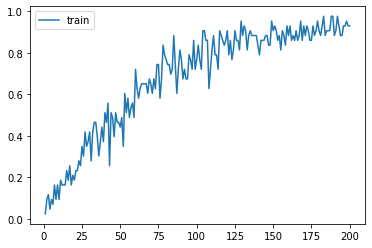

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [22]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [117]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado tfidf segun los datos de entrnamiento del modelo
def tfidf_input(text, vocab, train_ohe, train_frec): 
    tokens = text_to_tokens(text)
    frec = [0] * len(vocab)
    ohe = [0] * len(vocab)
    for idx, word in enumerate(vocab):
      frec[idx] = tokens.count(word)
      ohe[idx] = tokens.count(word) > 0 
    
    frec_con_input = np.append([frec], train_frec, axis=0)
    ohe_con_input = np.append([ohe], train_ohe, axis=0)
    idf_con_input = idf(ohe_con_input)
    train_X_tfidf_con_input = tfidf(frec_con_input, idf_con_input)
    return train_X_tfidf_con_input[0]

# usar modelo con la entrada en frec y los labels posibles (tags)
def pred_class(text, vocab, labels, train_ohe, train_frec): 
    tfidf_con_input = tfidf_input(text, vocab,train_ohe ,train_frec)
    words_recognized = sum(tfidf_con_input)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([tfidf_con_input]))[0]
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    print(type(return_list))
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [118]:
print("BOT: Welcome to Olympo, the AI bot which knows best about the Olympic games")
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, voc, classes,train_X_OHE,train_X_frec)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Sorry, I don't understand the question.")
    

BOT: Welcome to Olympo, the AI bot which knows best about the Olympic games
Hello
Q: Hello
1/1 [==============================] - 0s 31ms/step
<class 'list'>
BOT: Hello! Welcome to the Olympics, what would you like to know?
What's the best sport in the olmpics?
Q: What's the best sport in the olmpics?
<class 'list'>
BOT: Sorry, I don't understand the question.
What's the best sport in the olympics?
Q: What's the best sport in the olympics?
1/1 [==============================] - 0s 31ms/step
<class 'list'>
BOT: Hello! What are you interested in knowing about the Olympics?
medals
Q: medals
1/1 [==============================] - 0s 24ms/step
<class 'list'>
BOT: Medals are awarded to athletes who achieve the best results in their disciplines, and are divided into gold, silver, and bronze
Do the give medals in the olympics?
Q: Do the give medals in the olympics?
1/1 [==============================] - 0s 27ms/step
<class 'list'>
BOT: Medals are awarded to athletes who achieve the best result

KeyboardInterrupt: ignored

### 7 - Conclusiones
Utilicé un dataset en inglés para poder realizar stopwwords removal de ntlk. Además habiendo vectorizado utilizando TFIDF, tuvimos un modelo mas robusto y que desempeña mejor. Se comprueba ya que no solo al únicamente arrojarle palabras claves de los patterns, sino también haciendo preguntas sobre los temas del dataset, el modelo devuelve respuestas coherentes con la pregunta; son preguntas análogas a las del dataset, pero compuestas por palabras distintas, creo que esto es un aspecto muy desacable. Una manera de seguir mejorando el modelo sería teniendo mas datos en nuestro dataset.